# 1. Import & 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
import collections
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
%matplotlib inline

In [2]:
Covid = pd.read_csv("./[코로나] 3cluster.csv", encoding='utf-8-sig')
Covid.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
Covid = Covid.reset_index(drop=True)

# ['토큰'] 칼럼 콤마 기준 스플릿
for i in range(len(Covid)):

    covid_tocken=[]

    Covid['토큰'][i] = Covid['토큰'][i][1:-1].split(', ')
    for j in Covid['토큰'][i]:
        covid_tocken.append(j[1:-1])

    Covid['토큰'][i] = covid_tocken

Covid.head(1)

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,...,소관위원회,제안자,법률안,제안정당,법률공포여부,텍스트,토큰,명사수,문장벡터,category
0,2024549,처,감염병의 예방 및 관리에 관한 법률 일부개정법률안,의원,2020-01-28,2020-02-26 00:00:00,대안반영폐기,NaN,의안원문,제20대 (2016~2020) 제375회,...,보건복지위원회,"[""['유의동(새로운보수당/兪義東)'"", "" '권성동(자유한국당/權性東)'"", "" ...",1.0,"['미래를향한전진4.0', '자유한국당', '바른미래당', '새로운보수당']",미공포,감염병의 예방 및 관리에 관한 법률 일부개정법률안 최근 신종 코로나바이러스감염증...,"[감염병, 예방, 관리, 법률, 일부개정법률안, 신종, 코로나바이러스감염증, 국내,...",59,[ 0.03771923 0.03217825 0.18394935 -0.009044...,2


In [3]:
covid = Covid.copy()

#### 클러스터 별로 나누어 데이터셋 만들기

In [4]:
# category == 0
covid_0 = covid[covid['category']==0]
covid_0 = covid_0.reset_index(drop=True)
covid_0['category'].describe()

count    87.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: category, dtype: float64

In [5]:
# category == 1
covid_1 = covid[covid['category']==1]
covid_1 = covid_1.reset_index(drop=True)
covid_1['category'].describe()

count    12.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: category, dtype: float64

In [6]:
# category == 2
covid_2 = covid[covid['category']==2]
covid_2 = covid_2.reset_index(drop=True)
covid_2['category'].describe()

count    290.0
mean       2.0
std        0.0
min        2.0
25%        2.0
50%        2.0
75%        2.0
max        2.0
Name: category, dtype: float64

## 2. TopicMdeling

#### 함수

In [7]:
# 의미없는 단어 제거

def remove_stopword(text): 
    stopwords = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음’,’정책','일부','개정','최근',
                '집단','국내','의거','거나','함안','시행','이하','기한', '위해', '장관', '특별법', '마련','제호','임안','조사','운영','기관', '또한', '포함', '내용', 
                 '명시', '촉진', '근거', '실시', '지정', '현행', '의무', '확인', '도지사', '대통령령', '업무', '제출','대해', '제조','제항', '일부개정법률안','조제항',
                 '제조의제항','관련','만원','천만원','억원','연장함','해당','제조제항제호','법률','신설','이하','시행','사항','제호','포함','코로나바이러스감염증','일부개정법률안의안번호',
                 '비롯','곳곳','허영','제조제호','요청','걷기여행길','초과','지적','이상','규정하','전제','감염병','제기','대면중소벤처기업','비대']
    text = [word for word in text if word not in stopwords]
    return text


# 말뭉치

def make_corpus(cleanlist):

    dictionary = corpora.Dictionary(cleanlist) # cleanlist = 토큰화 한 리스트
    corpus = [dictionary.doc2bow(text) for text in cleanlist] 
    
    return corpus, dictionary, cleanlist




# 많이 나오는 단어 확인

def check_common(cleanlist):
    

    collections.Counter()

    flat=[]
    for i in cleanlist:
        for j in i:
            flat.append(j)
                    
                    
    commoncount = collections.Counter(flat)
    commoncount = commoncount.most_common(20) # 상위 20개 단어 + 빈도수가 들어있음

    commondict = [] # 제거할 수 있으므로 상위 20개 단어만 리스트에 넣어놓기

    for i in range(len(commoncount)): #50
        commondict.append(commoncount[i][0])

    commoncount

    return commoncount, commondict




# 토픽 수 최적화

def coh_visual(corpus, dictionary, cleanlist):
    
    coherence_values = []
    
    for i in tqdm(range(2,20), desc = 'coh'):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        coherence_model_lda = CoherenceModel(model = ldamodel, texts = cleanlist, dictionary = dictionary, topn=10)
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
    
    x = range(2,20)
    plt.plot(x, coherence_values)
    plt.xlabel('number of topics')
    plt.ylabel('coherence score')
    plt.show()
    



# 언어모델 평가

def perp_visual(corpus, dictionary):
    
    perplexity_values = []
    
    for i in tqdm(range(2,20),desc = 'perp'):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        perplexity_values.append(ldamodel.log_perplexity(corpus))
    
    x = range(2,20)
    plt.plot(x, perplexity_values)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity score')
    plt.show()


# 사이킷런 - LDA
def display_topics(model, feature_names, no_top_words):
    
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)
        
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes = topic_word_indexes[:no_top_words]
        
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)
        

### ① 0번 클러스터

#### 빈도수 높은  단어 확인

In [10]:
# 무의미한 단어 삭제
for i in range(len(covid_0)):
    covid_0['토큰'][i] = remove_stopword(covid_0['토큰'][i])

covid_0_clean = covid_0['토큰']

# 빈도 수 높은 단어 출력
covid_0_commoncount, covid_0_commondict = check_common(covid_0_clean)
covid_0_commoncount

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[('감면', 91),
 ('부가가치세', 85),
 ('적용', 76),
 ('확대', 58),
 ('간이과세', 57),
 ('개인사업자', 56),
 ('기업', 56),
 ('조세특례제한법', 55),
 ('법인세', 53),
 ('기준금액', 53),
 ('감소', 51),
 ('확산', 49),
 ('중소기업', 49),
 ('면제', 49),
 ('일몰기한', 48),
 ('상향', 47),
 ('장기화', 47),
 ('어려움', 45),
 ('필요', 45),
 ('연장', 45)]

### 말뭉치 만들기

In [11]:
covid_0_corpus, covid_0_dictionary, covid_0_cleanlist = make_corpus(covid_0_clean)

### Topic 수 결정

coh: 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]


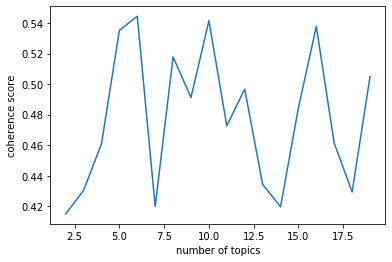

In [12]:
coh_visual(covid_0_corpus, covid_0_dictionary, covid_0_cleanlist)

perp: 100%|██████████| 18/18 [00:03<00:00,  5.48it/s]


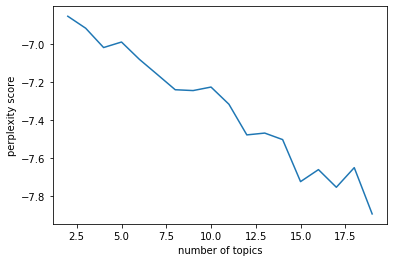

In [13]:
perp_visual(covid_0_corpus, covid_0_dictionary)

=> number of topics = 6으로 결정

### 토픽모델링 시각화 - Gensim

In [14]:
ldamodel = gensim.models.ldamodel.LdaModel(covid_0_corpus, num_topics=6, alpha=0.1, id2word = covid_0_dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, covid_0_corpus, covid_0_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.097781  0.026317       1        1  32.783070
2      0.018289 -0.006777       2        1  19.321354
3     -0.042765 -0.004268       3        1  13.029861
5     -0.000806  0.021519       4        1  12.635696
4     -0.004327 -0.080237       5        1  11.620589
1     -0.068172  0.043445       6        1  10.609422, topic_info=      Term       Freq      Total Category  logprob  loglift
71    소상공인  29.000000  29.000000  Default  30.0000  30.0000
99     임대료  28.000000  28.000000  Default  29.0000  29.0000
711  새마을금고  14.000000  14.000000  Default  28.0000  28.0000
1       감면  73.000000  73.000000  Default  27.0000  27.0000
69     소득세  33.000000  33.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
70     소상공   3.882496  28.418518   Topic6  -5.2252   0.2529
471     연장   4.092371  37.436737   Topic6  -5.1726   0.0299
155     필요   4.013173  37.975639   Topic6  -5.1921  -0.0039
149    장기화   3.895261  39.979866   Topic6  -5.2219  -0.0852
122     특례   3.605223  28.190573   Topic6  -5.2993   0.1868

[426 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
227       1  0.315082     가중
227       2  0.105027     가중
227       3  0.105027     가중
227       4  0.315082     가중
227       5  0.210055     가중
...     ...       ...    ...
135       4  0.074686    활성화
135       5  0.373430    활성화
135       6  0.074686    활성화
510       6  0.652170  활성화하기
1066      3  0.613156     후계

[903 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 6, 5, 2])

### 토픽모델링 - 사이킷런 LDA

In [15]:
covid_0_clean_flat=[]

for i in covid_0_clean:
    for j in i:
        covid_0_clean_flat.append(j)

covid_0_count_vect = CountVectorizer(max_df = 1.0, max_features = 1000, min_df = 10, ngram_range = (1,2))
covid_0_fit_vect = covid_0_count_vect.fit_transform(covid_0_clean_flat)

covid_0_lda = LatentDirichletAllocation(n_components = 6, random_state = 0)
covid_0_lda.fit(covid_0_fit_vect)
        
covid_0_feature_names = covid_0_count_vect.get_feature_names()

display_topics(covid_0_lda, covid_0_feature_names, 15)

Topic # 0
부가가치세 면제 소상공 경제적 경제 비과세 경기 조세특례 소규모 간이과세자 임대인 세제지원 증여세 피해 천백만원
Topic # 1
감면 법인세 어려움 연장 임대료 과세특례 부담 직전 예정 부가가치세법 축소 소비 법인세율 양도소득세 세제
Topic # 2
적용 확대 기업 필요 소득세 특례 농어업 이상 사태 일몰 납부의무 매출액 지속 인상 소득
Topic # 3
확산 상향 장기화 위축 기준 금액 어업용 미만 간이과세제도 지역 완화 지적 하락 종료 도모
Topic # 4
간이과세 개인사업자 조세특례제한법 감소 소상공인 상황 혜택 영세 취득세 정부 지속적 제기 법률안 코로나 지역경제
Topic # 5
기준금액 중소기업 일몰기한 공제 이후 매출 농어민 기자재 경감 세액공제 악화 수준 경제활동 침체 경쟁력


### ② 1번 클러스터

#### 무의미한 단어 삭제 및 빈도수 높은 단어 확인

In [10]:
# 무의미한 단어 삭제
for i in range(len(covid_1)):
    covid_1['토큰'][i] = remove_stopword(covid_1['토큰'][i])

covid_1_clean = covid_1['토큰']

# 빈도 수 높은 단어 출력
covid_1_commoncount, covid_1_commondict = check_common(covid_1_clean)
covid_1_commoncount

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[('기후변화', 88),
 ('법률안', 24),
 ('의결', 24),
 ('예산', 22),
 ('기금', 22),
 ('보고서', 20),
 ('지방자치단체', 16),
 ('지구온난화', 12),
 ('기상', 12),
 ('변화', 12),
 ('우리나라', 12),
 ('세계', 12),
 ('급격', 12),
 ('신종', 12),
 ('전염병', 12),
 ('하나', 12),
 ('의견', 12),
 ('국민', 12),
 ('건강', 12),
 ('위협', 12)]

#### 말뭉치 만들기

In [11]:
covid_1_corpus, covid_1_dictionary, covid_1_cleanlist = make_corpus(covid_1_clean)

#### Topic 수 결정

coh: 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


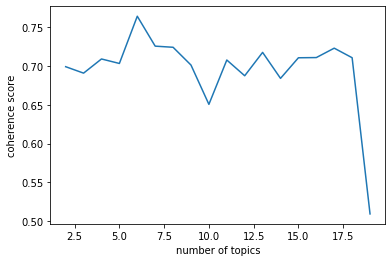

In [12]:
coh_visual(covid_1_corpus, covid_1_dictionary, covid_1_cleanlist)

perp: 100%|██████████| 18/18 [00:00<00:00, 34.83it/s]


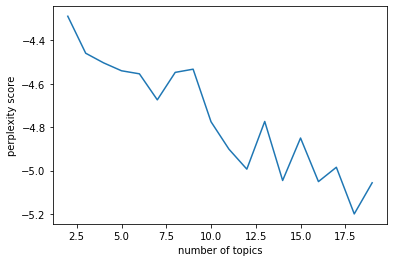

In [13]:
perp_visual(covid_1_corpus, covid_1_dictionary)

=> number of topics = 4로 결정

#### 토픽모델링 시각화 - Gensim

In [18]:
ldamodel = gensim.models.ldamodel.LdaModel(covid_1_corpus, num_topics=4, alpha=0.1, id2word = covid_1_dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, covid_1_corpus, covid_1_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.019518 -0.002947       1        1  77.289490
1     -0.012259 -0.017123       2        1  11.691401
2      0.031913  0.008916       3        1  10.871861
0     -0.039172  0.011154       4        1   0.147253, topic_info=    Term       Freq      Total Category  logprob  loglift
11  기후변화  85.000000  85.000000  Default  30.0000  30.0000
18   법률안  22.000000  22.000000  Default  29.0000  29.0000
8     기금  21.000000  21.000000  Default  28.0000  28.0000
30    예산  20.000000  20.000000  Default  27.0000  27.0000
36    의결  24.000000  24.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
24  수정의결   0.015905  11.916135   Topic4  -4.3174  -0.0983
27    심도   0.015902  11.479278   Topic4  -4.3176  -0.0611
23    속도   0.015902  11.705465   Topic4  -4.3176  -0.0806
2     건강   0.015901  11.822979   Topic4  -4.3176  -0.0907
1     감안   0.015900  12.408731   Topic4  -4.3177  -0.1390

[203 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.814227  가속화
0         2  0.081423  가속화
0         3  0.081423  가속화
1         1  0.805884   감안
1         2  0.161177   감안
...     ...       ...  ...
65        1  0.715061   필요
65        2  0.357531   필요
51        1  0.750223   하나
51        2  0.166716   하나
51        3  0.083358   하나

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

#### 토픽모델링 - 사이킷런 LDA

In [19]:
covid_1_clean_flat=[]

for i in covid_1_clean:
    for j in i:
        covid_1_clean_flat.append(j)

covid_1_count_vect = CountVectorizer(max_df = 1.0, max_features = 1000, min_df = 5, ngram_range = (1,2))
covid_1_fit_vect = covid_1_count_vect.fit_transform(covid_1_clean_flat)

covid_1_lda = LatentDirichletAllocation(n_components = 4, random_state = 0)
covid_1_lda.fit(covid_1_fit_vect)
        
covid_1_feature_names = covid_1_count_vect.get_feature_names()

display_topics(covid_1_lda, covid_1_feature_names, 15)

Topic # 0
기후변화 법률안 국민 가속화 건강 방향 집행 도입 세계 광범위 감안 분석 우리나라 하나 정부
Topic # 1
의결 기금 문제 수준 의견 단계 속도 조정 영향 완화 결산 정부 하나 분석 우리나라
Topic # 2
예산 지방자치단체 심도 변화 대표발의 참고사항 결산제도 의원 지구온난화 수정의결 전제 종합적 제기 지적 대응
Topic # 3
보고서 기상 전염병 예산편성 위협 신종 급격 평가 정부 하나 우리나라 감안 분석 도입 세계


### ③ 2번 클러스터

#### 무의미한 단어 삭제 및 빈도수 높은 단어 확인

In [8]:
# 무의미한 단어 삭제
for i in range(len(covid_2)):
    covid_2['토큰'][i] = remove_stopword(covid_2['토큰'][i])

covid_2_clean = covid_2['토큰']

# 빈도 수 높은 단어 출력
covid_2_commoncount, covid_2_commondict = check_common(covid_2_clean)
covid_2_commoncount

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[('필요', 286),
 ('상황', 196),
 ('확산', 147),
 ('예방', 143),
 ('정부', 116),
 ('근로자', 99),
 ('국민', 97),
 ('강화', 86),
 ('지방자치단체', 86),
 ('조치', 84),
 ('대응', 80),
 ('지역', 78),
 ('확대', 77),
 ('보호', 76),
 ('마스크', 75),
 ('부담', 75),
 ('법률안', 73),
 ('재난', 69),
 ('사태', 67),
 ('의결', 65)]

#### 말뭉치 만들기

In [9]:
covid_2_corpus, covid_2_dictionary, covid_2_cleanlist = make_corpus(covid_2_clean)

#### Topic 수 결정

coh: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


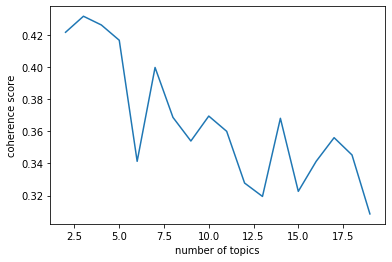

In [10]:
coh_visual(covid_2_corpus, covid_2_dictionary, covid_2_cleanlist)

perp: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


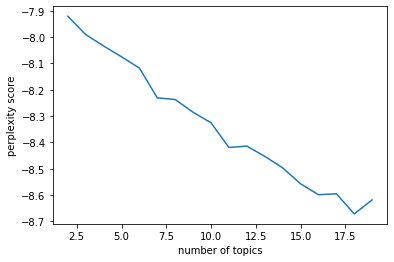

In [11]:
perp_visual(covid_2_corpus, covid_2_dictionary)

=> number of topics = 7로 결정

#### 토픽 모델링 시각화 - Gensim

In [12]:
ldamodel = gensim.models.ldamodel.LdaModel(covid_2_corpus, num_topics=7, alpha=0.1, id2word = covid_2_dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, covid_2_corpus, covid_2_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.007530  0.046456       1        1  23.878712
4     -0.078817  0.018000       2        1  23.628389
2      0.037916  0.018322       3        1  20.152143
0      0.069652 -0.007514       4        1  20.062117
1     -0.021221 -0.075264       5        1  12.278641, topic_info=        Term        Freq       Total Category  logprob  loglift
3583  경제자유구역   31.000000   31.000000  Default  30.0000  30.0000
766      등록금   42.000000   42.000000  Default  29.0000  29.0000
28        필요  247.000000  247.000000  Default  28.0000  28.0000
4514   스포츠산업   15.000000   15.000000  Default  27.0000  27.0000
489     소상공인   39.000000   39.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
282       확산    9.794404  123.310120   Topic5  -5.6319  -0.4356
102       대응    7.796941   68.167961   Topic5  -5.8600  -0.0709
126       실정    6.823038   45.799477   Topic5  -5.9934   0.1933
474       부담    6.983574   63.021069   Topic5  -5.9701  -0.1026
218       학교    6.534445   40.387245   Topic5  -6.0366   0.2759

[401 rows x 6 columns], token_table=      Topic      Freq Term
term                      
534       3  0.188992   가입
534       4  0.755970   가입
535       3  0.227585  가입한
535       4  0.682756  가입한
2120      4  0.758869   각광
...     ...       ...  ...
188       1  0.146755  효율적
188       2  0.036689  효율적
188       3  0.146755  효율적
188       4  0.513643  효율적
188       5  0.146755  효율적

[860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

#### 토픽모델링 - 사이킷런 LDA

In [14]:
covid_2_clean_flat=[]

for i in covid_2_clean:
    for j in i:
        covid_2_clean_flat.append(j)

covid_2_count_vect = CountVectorizer(max_df = 0.95, max_features = 1000, min_df = 20, ngram_range = (1,2))
covid_2_fit_vect = covid_2_count_vect.fit_transform(covid_2_clean_flat)

covid_2_lda = LatentDirichletAllocation(n_components = 7, random_state = 0)
covid_2_lda.fit(covid_2_fit_vect)
        
covid_2_feature_names = covid_2_count_vect.get_feature_names()

display_topics(covid_2_lda, covid_2_feature_names, 15)

Topic # 0
필요 상황 조치 보건복지부장관 학생 원격수업 어려움 경제 가능 제도 증가 학생들 참고사항 사유 공급
Topic # 1
정부 지역 법률안 재난 사용 기업 시설 문제 우려 소상공 건강 질병 도모 국립공공보건의료대학 변화
Topic # 2
예방 근로자 감염 코로나 유행 지속적 방지 학교 이후 수업 교육 손실 수행 비용 수준
Topic # 3
강화 사태 등록금 수립 이용 활성화 지급 추진 사람 신종 정책 환자 요구 부족 의약품
Topic # 4
지방자치단체 보호 부담 의료기관 장기화 추가 도입 기준 대비 경제자유구역 설치 우리나라 제공 안전관리 분야
Topic # 5
확산 국민 대응 의결 필요성 조정 실정 설립 소상공인 활용 심각 피해 인정 증진 기반
Topic # 6
확대 마스크 사회적 육성 범위 체계적 인력 위반 대상 방역 바이러스 기간 구축 감소 해외
